In [1]:
import os
from tqdm import tqdm
import numpy as np
from pathlib import Path
import argparse
import logging
import torch
from torch.utils.data import DataLoader
#import wandb
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (Trainer, TrainingArguments, DataCollatorWithPadding,
                          AutoTokenizer, AutoModelForSequenceClassification)

In [16]:
#load multirc dataset from HF
multirc = load_dataset("super_glue", "multirc")

In [17]:
multirc

DatasetDict({
    train: Dataset({
        features: ['paragraph', 'question', 'answer', 'idx', 'label'],
        num_rows: 27243
    })
    validation: Dataset({
        features: ['paragraph', 'question', 'answer', 'idx', 'label'],
        num_rows: 4848
    })
    test: Dataset({
        features: ['paragraph', 'question', 'answer', 'idx', 'label'],
        num_rows: 9693
    })
})

In [20]:
len(set(multirc['train']['paragraph']))

456

In [21]:
len(set(multirc['train']['question']))

5130

In [2]:
model_name_or_path = "microsoft/mpnet-base"
dataset_path = '../bin/multirc_dataset.hf'
output_dir = 'results/hp-tuning'
model_max_length = 512
eval_steps = 1000
eval_accumulation_steps = 2
save_total_limit = 4
batch_size = 32
num_epochs = 4
learning_rate = 3e-05
seed = 42
metric = 'accuracy'
entity = 'ai-aloe'
project_name = 'short answer scoring'

id2label = {0: "incorrect_answer", 1: "correct_answer"}
label2id = {"incorrect_answer": 0, "correct_answer": 1}

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    max_length=model_max_length,
    )

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path,
                                                               num_labels=2,
                                                               id2label=id2label,
                                                               label2id=label2id)
    return model

In [3]:
ds = DatasetDict.load_from_disk(dataset_path)

In [7]:
ds['train']['text']

['Tornadoes</s>\nAnswer: Earthquakes and tsunamis.',
 'Avalanches</s>\nAnswer: Earthquakes and tsunamis.',
 'Earthquakes and tsunamis</s>\nAnswer: Earthquakes and tsunamis.',
 'Earthquakes</s>\nAnswer: Earthquakes and tsunamis.',
 'Ice storms and flooding</s>\nAnswer: Earthquakes and tsunamis.',
 'Tsunamis</s>\nAnswer: Earthquakes and tsunamis.',
 'Because Malaysia stated that the plane may have been flown into the Indian Ocean</s>\nChinese and Vietnamese officials are critical of the Malaysian response because Malaysian officials have created confusion by issuing contradictory statements on key aspects of the investigation and have wasted the "golden time for saving possible survivors" by searching in the wrong area.',
 'Ineffective rescue efforts</s>\nChinese and Vietnamese officials are critical of the Malaysian response because Malaysian officials have created confusion by issuing contradictory statements on key aspects of the investigation and have wasted the "golden time for savi

In [32]:
def preprocess_function(example):
    return tokenizer(example["text"], padding=True, truncation=True)

ds = ds.map(preprocess_function, batched=False)

Map:   0%|          | 0/3962 [00:00<?, ? examples/s]

Dataset({
    features: ['index', 'text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 19170
})

In [5]:
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length')

In [9]:
import os
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/mpnet_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    logging_dir = f'./logs/content',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    evaluation_strategy = "epoch",
    save_strategy = "epoch", 
    greater_is_better = True,
    seed=seed,
    log_level = 'error',  
    disable_tqdm = False, 
) 

    # Call the Trainer
trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = ds['train'],
    eval_dataset = ds['valid'],
    compute_metrics = compute_metrics
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.301706,0.912844
2,No log,0.244343,0.922018
3,No log,0.202280,0.940367
4,No log,0.212523,0.928899


TrainOutput(global_step=256, training_loss=0.28110426664352417, metrics={'train_runtime': 223.9278, 'train_samples_per_second': 36.28, 'train_steps_per_second': 1.143, 'total_flos': 2137514213744640.0, 'train_loss': 0.28110426664352417, 'epoch': 4.0})

In [10]:
import time

start_time = time.time()
preds, labels, metrics= trainer.predict(ds['test'])
predictions = np.argmax(preds, axis=1)
end_time = time.time()
print(end_time-start_time)

3.79007887840271


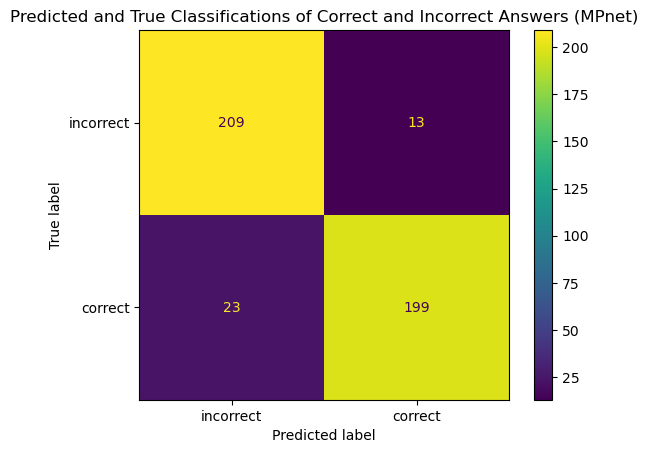

In [11]:
from sklearn import metrics
from matplotlib import pyplot as plt

confusion_matrix = metrics.confusion_matrix(labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['incorrect', 'correct'])

cm_display.plot()
plt.title('Predicted and True Classifications of Correct and Incorrect Answers (MPnet)')
plt.show()

In [9]:
print(metrics.classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       222
           1       0.93      0.92      0.93       222

    accuracy                           0.93       444
   macro avg       0.93      0.93      0.93       444
weighted avg       0.93      0.93      0.93       444



In [10]:
trainer.save_model("../bin/mpnet_classifier")

In [16]:
import sklearn
sklearn.metrics.cohen_kappa_score(labels, predictions)

0.8378378378378378

In [13]:
import torch
import gc
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from transformers import AutoModelForSequenceClassification
preds = []
model = AutoModelForSequenceClassification.from_pretrained("../bin/mpnet_multimc_classifier").to(device)
for text in ds['test']['text']:
    inputs = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    preds.append(model.config.id2label[predicted_class_id])


cuda


In [23]:
labels = []
for x in ds['test']['labels']:
    if x == 1:
        labels.append('correct_answer' )
    else: 
        labels.append('incorrect_answer') 

from sklearn import metrics
from matplotlib import pyplot as plt

print(metrics.classification_report(labels, preds))

                  precision    recall  f1-score   support

  correct_answer       0.80      0.76      0.78      1722
incorrect_answer       0.82      0.85      0.84      2240

        accuracy                           0.81      3962
       macro avg       0.81      0.81      0.81      3962
    weighted avg       0.81      0.81      0.81      3962



In [27]:
from huggingface_hub import notebook_login
notebook_login()


In [29]:
model.push_to_hub("short-answer-classification")
tokenizer.push_to_hub("short-answer-classification")

CommitInfo(commit_url='https://huggingface.co/tiedaar/short-answer-classification/commit/30da339a79dd1334063ce2f5ba64d6df1d676055', commit_message='Upload tokenizer', commit_description='', oid='30da339a79dd1334063ce2f5ba64d6df1d676055', pr_url=None, pr_revision=None, pr_num=None)

In [14]:
from datasets import load_dataset
import os

dataset = load_dataset("tiedaar/question_scoring_stresstest")['train'].to_pandas()
dataset

,subsection_num,source,question,answer,mpnet_response,bleurt_response,correct_response


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ABC', 'Hello World', '2023-05-10 04:53:08.014230'],
        num_rows: 202
    })
})